In [1]:
# pip install catboost xgboost category_encoders lightgbm

In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import warnings
import pickle

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from collections import Counter
from itertools import combinations
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
import lightgbm as lgb


warnings.filterwarnings('ignore')
mlp.rcParams["figure.figsize"] = [18,8]

# 1. Familization with data

In [3]:
df = pd.read_excel("../Software Vacancy.xlsx")
df.head()

Unnamed: 0                                               Name  \
0           0               Mobil tətbiq üzrə məhsul mütəxəssisi   
1           1                           Senior Backend Developer   
2           2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...   
3           3                                  Mid IOS Developer   
4           4                             IOS Developer (middle)   

                                      Url to Vacancy         Company Location  \
0  https://busy.az/vacancy/132205/mobil-tetbiq-uz...        189 Taxi     Bakı   
1  https://busy.az/vacancy/132086/senior-backend-...  Ferrum Capital     Bakı   
2  https://busy.az/vacancy/132034/proqramlasdirma...       Xalq Bank     Bakı   
3   https://busy.az/vacancy/132014/mid-ios-developer      Golden Pay     Bakı   
4  https://busy.az/vacancy/131978/ios-developer-m...    Express Bank     Bakı   

     Type of Employment Age category Education degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   

  Posting Date Deadline Date  \
0   04.07.2024    18.07.2024   
1   03.07.2024    17.07.2024   
2   03.07.2024    17.07.2024   
3   03.07.2024    17.07.2024   
4   03.07.2024    17.07.2024   

                                              Skills  
0  ['software development', 'programming', 'mobil...  
1  ['Oracle', 'T-SQL', 'OOP', 'back-end developme...  
2  ['SQL', 'back-end development', 'programming',...  
3  ['proqramlaşdırma', 'iOS development', 'progra...  
4  ['OOP', 'proqramlaşdırma', 'iOS development', ...

In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

Name  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi   
1                           Senior Backend Developer   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...   
3                                  Mid IOS Developer   
4                             IOS Developer (middle)   

                                      Url to Vacancy         Company Location  \
0  https://busy.az/vacancy/132205/mobil-tetbiq-uz...        189 Taxi     Bakı   
1  https://busy.az/vacancy/132086/senior-backend-...  Ferrum Capital     Bakı   
2  https://busy.az/vacancy/132034/proqramlasdirma...       Xalq Bank     Bakı   
3   https://busy.az/vacancy/132014/mid-ios-developer      Golden Pay     Bakı   
4  https://busy.az/vacancy/131978/ios-developer-m...    Express Bank     Bakı   

     Type of Employment Age category Education degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   

  Posting Date Deadline Date  \
0   04.07.2024    18.07.2024   
1   03.07.2024    17.07.2024   
2   03.07.2024    17.07.2024   
3   03.07.2024    17.07.2024   
4   03.07.2024    17.07.2024   

                                              Skills  
0  ['software development', 'programming', 'mobil...  
1  ['Oracle', 'T-SQL', 'OOP', 'back-end developme...  
2  ['SQL', 'back-end development', 'programming',...  
3  ['proqramlaşdırma', 'iOS development', 'progra...  
4  ['OOP', 'proqramlaşdırma', 'iOS development', ...

In [5]:
df.shape

(1796, 11)

In [6]:
df.isna().sum()

Name                     0
Url to Vacancy           0
Company                  0
Location               623
Type of Employment       0
Age category          1717
Education degree      1058
Salary                   0
Posting Date             8
Deadline Date            8
Skills                   0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                1796 non-null   object
 1   Url to Vacancy      1796 non-null   object
 2   Company             1796 non-null   object
 3   Location            1173 non-null   object
 4   Type of Employment  1796 non-null   object
 5   Age category        79 non-null     object
 6   Education degree    738 non-null    object
 7   Salary              1796 non-null   object
 8   Posting Date        1788 non-null   object
 9   Deadline Date       1788 non-null   object
 10  Skills              1796 non-null   object
dtypes: object(11)
memory usage: 154.5+ KB


In [8]:
df.duplicated().sum()

13

In [9]:
df[df.duplicated(keep=False)][:2]

Name                               Url to Vacancy Company  \
442  PHP Developer  https://busy.az/vacancy/98258/php-developer  Push30   
443  PHP Developer  https://busy.az/vacancy/98258/php-developer  Push30   

    Location    Type of Employment Age category Education degree  \
442     Bakı  Tam ştat (full time)          NaN   Ali (bakalavr)   
443     Bakı  Tam ştat (full time)          NaN   Ali (bakalavr)   

                 Salary Posting Date Deadline Date  \
442  Razılaşma yolu ilə   25.04.2023    25.05.2023   
443  Razılaşma yolu ilə   25.04.2023    25.05.2023   

                                                Skills  
442  ['HTML', 'CSS', 'JavaScript', 'programming', '...  
443  ['HTML', 'CSS', 'JavaScript', 'programming', '...

# 2. Cleaning
* Change posting_date and deadline data type to `date`
* Delete all strip in values
* Replaced some values in columns
* Delete `[]` and duplicated, change test case to titled in skills
* Fill NA with `mode` and `mean`
* Added `Year`, `Mounth`, `Day` columns

In [10]:
df_clean = df.copy(deep=True)
df_clean["Id"] = df_clean.index

df_clean.columns = df_clean.columns.str.replace(" ","_")
df_clean.head()

Name  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi   
1                           Senior Backend Developer   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...   
3                                  Mid IOS Developer   
4                             IOS Developer (middle)   

                                      Url_to_Vacancy         Company Location  \
0  https://busy.az/vacancy/132205/mobil-tetbiq-uz...        189 Taxi     Bakı   
1  https://busy.az/vacancy/132086/senior-backend-...  Ferrum Capital     Bakı   
2  https://busy.az/vacancy/132034/proqramlasdirma...       Xalq Bank     Bakı   
3   https://busy.az/vacancy/132014/mid-ios-developer      Golden Pay     Bakı   
4  https://busy.az/vacancy/131978/ios-developer-m...    Express Bank     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              NaN  Razılaşma yolu ilə   

  Posting_Date Deadline_Date  \
0   04.07.2024    18.07.2024   
1   03.07.2024    17.07.2024   
2   03.07.2024    17.07.2024   
3   03.07.2024    17.07.2024   
4   03.07.2024    17.07.2024   

                                              Skills  Id  
0  ['software development', 'programming', 'mobil...   0  
1  ['Oracle', 'T-SQL', 'OOP', 'back-end developme...   1  
2  ['SQL', 'back-end development', 'programming',...   2  
3  ['proqramlaşdırma', 'iOS development', 'progra...   3  
4  ['OOP', 'proqramlaşdırma', 'iOS development', ...   4

In [11]:
df_clean["Posting_Date"] = pd.to_datetime(df_clean["Posting_Date"], format="%d.%m.%Y")
df_clean["Deadline_Date"] = pd.to_datetime(df_clean["Deadline_Date"], format="%d.%m.%Y")

In [12]:
df_clean['Month'] = df_clean['Posting_Date'].dt.month
df_clean['Year'] = df_clean['Posting_Date'].dt.year
df_clean['Day'] = df_clean['Posting_Date'].dt.day

In [13]:
df_clean.drop("Url_to_Vacancy",axis=1,inplace=True)

for col in df_clean.select_dtypes(include="object").columns:
    df_clean[col] = df_clean[col].str.strip()

In [14]:
df_clean['Location'].value_counts()

Location
Bakı                                                                                                                                                                                                                                                             1158
Abşeron rayonu/Xırdalan                                                                                                                                                                                                                                             5
Sumqayıt                                                                                                                                                                                                                                                            4
Göygöl                                                                                                                                                                                                       

In [15]:
df_clean['Education_degree'].value_counts()

Education_degree
Ali               524
Ali (bakalavr)    211
Ali (Magistr)       2
Elmlər doktoru      1
Name: count, dtype: int64

In [16]:
print("Totalunique company count", df_clean['Company'].nunique())
df_clean['Company'].value_counts()

Totalunique company count 379


Company
Kapital Bank           57
eManat                 43
Bank Respublika ASC    41
Ateshgah Sigorta       39
PASHA Bank             36
                       ..
Fizza Pay               1
POS.az                  1
Capital XR              1
Engineering company     1
Oilfield Company        1
Name: count, Length: 379, dtype: int64

In [17]:
df_clean['Type_of_Employment'].value_counts()

Type_of_Employment
Tam ştat (full time)          1783
Təcrübəçi (stajor, intern)      11
Layihə/Müvəqqəti                 2
Name: count, dtype: int64

In [18]:
df_clean['Salary'].value_counts().head(20)

Salary
Razılaşma yolu ilə    1520
1500 - 2000             26
1200 - 1500             16
2000 - 3000             15
2000 - 2500             10
1500 - 2500             10
3000 - 3500              9
1000 - 1500              9
800                      7
1500                     7
2500 - 3500              7
1000                     6
700 - 1100               6
400                      6
1500 - 3000              5
2500 - 3000              5
2000                     5
600 - 1000               5
1000 - 1200              4
2000 - 3500              4
Name: count, dtype: int64

In [19]:
replacement_dict = {
    "2000 - 2500":"2000 - 3000",
    "1000 - 1400":"1200 - 1500",
    "1000 - 1500":"1200 - 1500",
    "1500 - 2000":"1500 - 2500",
    "3000 - 3500":"2500 - 3500",
    "1300 - 1500":"1200 - 1500",
    "1500 - 3000":"2000 - 3000",
    "3500 - 4500":"2500 - 5000",
    "800 - 1800":"1500 - 2000",

    "2250":"2000 - 3000",
    "1300":"1200 - 1500",
    "1200":"1200 - 1500",
    "2000":"1500 - 2000",
    "1500":"1200 - 1500",
    "3000":"2000 - 3000",
    "800":"1200 - 1500",
    "600 - 800":"300-800",
    "500 - 800":"300-800",
    "500":"500 - 1200",

    "1000":"700 - 1100",
    "400":"300-800",
}
df_clean['Salary'].replace(replacement_dict,inplace=True)

In [20]:
df_clean['Salary'].value_counts().head(20)

Salary
Razılaşma yolu ilə    1520
1200 - 1500             45
1500 - 2500             36
2000 - 3000             34
2500 - 3500             16
300-800                 14
700 - 1100              12
1500 - 2000              6
600 - 1000               5
2500 - 3000              5
1000 - 1200              4
2000 - 3500              4
800 - 1200               4
1200 - 1800              3
700 - 2500               3
800 - 1300               3
1000 - 3000              3
2000 - 4000              3
1500 - 1800              3
1000 - 2000              3
Name: count, dtype: int64

In [21]:
df_clean['Age_category'].value_counts()

Age_category
25  - 45    19
25  - 30    12
20  - 35    10
22  - 35     7
25  - 35     5
22  - 28     3
24  - 35     3
20  - 30     3
23  - 45     2
25  - 40     2
22  - 30     2
24           2
21  - 30     1
20  - 28     1
24  - 40     1
24  - 30     1
23  - 35     1
23  - 28     1
22  - 40     1
22  - 26     1
23  - 30     1
Name: count, dtype: int64

In [22]:
replacement_dict = {
    "20  - 30":"20  - 35",
    "20  - 28":"20  - 35",
    "21  - 30":"20  - 35",
    "22 - 35": "20  - 35",
    "22  - 28":"20  - 35",
    "22  - 30":"20  - 35",
    "22  - 35":"20  - 35",
    "22  - 26":"20  - 35",
    "23  - 30":"20  - 35",
    "23  - 28":"20  - 35",
    "23  - 35":"20  - 35",
    "24  - 35":"20  - 35",
    "25 - 30": "20  - 35",
    "25  - 35":"20  - 35",
    "24" : "20  - 35",

    "22  - 40":"25  - 45",
    "23  - 45":"25  - 45",
    "24  - 30":"25  - 30",
    "24  - 40":"25  - 45",
    "25  - 40":"25  - 45",
}

df_clean['Age_category'].replace(replacement_dict,inplace=True)

In [23]:
df_clean['Education_degree']  = df_clean['Education_degree'].replace("Ali (Magistr)","Ali")
df_clean['Location'] = df_clean['Location'].str.replace('\n', '', regex=False).replace('\t', '', regex=False).replace(r'\s+', '', regex=True)

In [24]:
def fill_na_with_mode(col_name):
    mode = df_clean[col_name].mode()[0]
    df_clean[col_name].fillna(mode,inplace=True)

fill_na_with_mode("Location")
fill_na_with_mode("Education_degree")

df_clean.isna().sum()

Name                     0
Company                  0
Location                 0
Type_of_Employment       0
Age_category          1717
Education_degree         0
Salary                   0
Posting_Date             8
Deadline_Date            8
Skills                   0
Id                       0
Month                    8
Year                     8
Day                      8
dtype: int64

In [25]:
df_clean.head()

Name         Company Location  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1                           Senior Backend Developer  Ferrum Capital     Bakı   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...       Xalq Bank     Bakı   
3                                  Mid IOS Developer      Golden Pay     Bakı   
4                             IOS Developer (middle)    Express Bank     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date  \
0   2024-07-04    2024-07-18   
1   2024-07-03    2024-07-17   
2   2024-07-03    2024-07-17   
3   2024-07-03    2024-07-17   
4   2024-07-03    2024-07-17   

                                              Skills  Id  Month    Year  Day  
0  ['software development', 'programming', 'mobil...   0    7.0  2024.0  4.0  
1  ['Oracle', 'T-SQL', 'OOP', 'back-end developme...   1    7.0  2024.0  3.0  
2  ['SQL', 'back-end development', 'programming',...   2    7.0  2024.0  3.0  
3  ['proqramlaşdırma', 'iOS development', 'progra...   3    7.0  2024.0  3.0  
4  ['OOP', 'proqramlaşdırma', 'iOS development', ...   4    7.0  2024.0  3.0

In [26]:
df_clean['Skills'] = df_clean['Skills'].str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace("'", '', regex=False)
df_clean['Skills'] = df_clean['Skills'].apply(lambda x: x.split(', '))
df_clean.head()

Name         Company Location  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1                           Senior Backend Developer  Ferrum Capital     Bakı   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...       Xalq Bank     Bakı   
3                                  Mid IOS Developer      Golden Pay     Bakı   
4                             IOS Developer (middle)    Express Bank     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date  \
0   2024-07-04    2024-07-18   
1   2024-07-03    2024-07-17   
2   2024-07-03    2024-07-17   
3   2024-07-03    2024-07-17   
4   2024-07-03    2024-07-17   

                                              Skills  Id  Month    Year  Day  
0  [software development, programming, mobile app...   0    7.0  2024.0  4.0  
1  [Oracle, T-SQL, OOP, back-end development, sof...   1    7.0  2024.0  3.0  
2  [SQL, back-end development, programming, proqr...   2    7.0  2024.0  3.0  
3  [proqramlaşdırma, iOS development, programming...   3    7.0  2024.0  3.0  
4  [OOP, proqramlaşdırma, iOS development, softwa...   4    7.0  2024.0  3.0

In [27]:
df_clean["Skills"].value_counts()

Skills
[proqramçı, programmer, software developer]                                                                                                            107
[Java developer, proqramçı, programmer, software developer]                                                                                             51
[software development, programming, proqramlaşdırma, proqram təminatı, программирование]                                                                16
[]                                                                                                                                                      15
[software development, programming, proqramlaşdırma, proqram təminatı]                                                                                  13
                                                                                                                                                      ... 
[HTML, CSS, JavaScript, TypeScript, JSON, SQL, PL/SQL, front-en

In [28]:
def change_skill(skill):

    replacement_dict = {
    "software development":"programming",
    "software developer":"programming",
    "proqram təminatı":"programming",
    "proqramlaşdırma":"programming",
    "programming":"programming",
    "программирование":"programming",
    "proqramçı":"programming",
    "programmer":"programming",
    "rus dili":"Russian language",

    "mobile application":"mobile development",
    "mobile application development":"mobile development"}

    for key in replacement_dict.keys():

        if skill == key:
            return replacement_dict[key]

    return skill


df_clean["Skills"]= df_clean["Skills"].apply(lambda x:  [change_skill(skill) for skill in x])

In [29]:
df_clean['Skills'] = df_clean['Skills'].apply(lambda x: set(x))
df_clean['Skills'] = df_clean['Skills'].apply(lambda x: str(x).replace("{", "").replace("}", "").replace("'", "").replace("[", "").replace("]", ""))

In [30]:
df_clean['Skills'] = df_clean['Skills'].str.title()
df_clean.Skills.value_counts()

Skills
Programming                                                                            227
Programming, Java Developer                                                             51
Programming, Android Development, Mobile Development                                    20
Programming, Back-End Development                                                       19
Programming, Mobile Development                                                         18
                                                                                      ... 
Programming, Bootstrap, Full Stack Development, Front-End Development, Jquery, Html      1
Programming, Oop, Mobile Development                                                     1
Programming, Javascript, Back-End Development                                            1
Programming, Russian Language, Python                                                    1
Jquery, Microsoft Excel, Microsoft Word, Microsoft Office                          

In [31]:
df_clean

Name  \
0                  Mobil tətbiq üzrə məhsul mütəxəssisi   
1                              Senior Backend Developer   
2     Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...   
3                                     Mid IOS Developer   
4                                IOS Developer (middle)   
...                                                 ...   
1791                                 Software Developer   
1792                                     Java Developer   
1793                                 Software Developer   
1794                        Process/Production Engineer   
1795  Information and Communication Technology Assis...   

                                                Company Location  \
0                                              189 Taxi     Bakı   
1                                        Ferrum Capital     Bakı   
2                                             Xalq Bank     Bakı   
3                                            Golden Pay     Bakı   
4                                          Express Bank     Bakı   
...                                                 ...      ...   
1791                                         Komtec Ltd     Bakı   
1792                                         Komtec Ltd     Bakı   
1793                                         Komtec Ltd     Bakı   
1794  Caspian Investment and Development Corporation...     Bakı   
1795                                   Oilfield Company     Bakı   

        Type_of_Employment Age_category Education_degree              Salary  \
0     Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1     Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
2     Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3     Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4     Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
...                    ...          ...              ...                 ...   
1791  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1792  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1793  Tam ştat (full time)          NaN   Ali (bakalavr)  Razılaşma yolu ilə   
1794  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1795  Tam ştat (full time)          NaN   Ali (bakalavr)           600 - 900   

     Posting_Date Deadline_Date  \
0      2024-07-04    2024-07-18   
1      2024-07-03    2024-07-17   
2      2024-07-03    2024-07-17   
3      2024-07-03    2024-07-17   
4      2024-07-03    2024-07-17   
...           ...           ...   
1791   2012-07-07    2012-08-06   
1792   2012-06-16    2012-07-16   
1793   2012-05-24    2012-06-23   
1794   2012-03-05    2012-04-04   
1795   2012-03-05    2012-04-04   

                                                 Skills    Id  Month    Year  \
0                       Programming, Mobile Development     0    7.0  2024.0   
1     Programming, T-Sql, Oracle, Oop, Java, Back-En...     1    7.0  2024.0   
2                Programming, Back-End Development, Sql     2    7.0  2024.0   
3      Programming, Ios Development, Mobile Development     3    7.0  2024.0   
4                     Programming, Ios Development, Oop     4    7.0  2024.0   
...                                                 ...   ...    ...     ...   
1791                                        Programming  1791    7.0  2012.0   
1792                            Programming, Javascript  1792    6.0  2012.0   
1793                                        Programming  1793    5.0  2012.0   
1794                         Programming, Web Developer  1794    3.0  2012.0   
1795  Jquery, Microsoft Excel, Microsoft Word, Micro...  1795    3.0  2012.0   

       Day  
0      4.0  
1      3.0  
2      3.0  
3      3.0  
4      3.0  
...    ...  
1791   7.0  
1792  16.0  
1793  24.0  
1794   5.0  
1795   5.0  

[1796 rows x 14 columns]

In [32]:
df_skill_extended = df_clean.copy(deep=True)

df_skill_extended['Skills'] = df_clean['Skills'].apply(lambda x: x.split(', ')).apply(lambda x: [item.strip() for item in x]) ## separate each word in skills
df_skill_extended = df_skill_extended.explode('Skills') # Transform each element of a list-like to a row, replicating index values.
df_skill_extended.reset_index(drop=True,inplace=True)

df_skill_extended.head()

Name         Company Location  \
0  Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1  Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
2              Senior Backend Developer  Ferrum Capital     Bakı   
3              Senior Backend Developer  Ferrum Capital     Bakı   
4              Senior Backend Developer  Ferrum Capital     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date              Skills  Id  Month    Year  Day  
0   2024-07-04    2024-07-18         Programming   0    7.0  2024.0  4.0  
1   2024-07-04    2024-07-18  Mobile Development   0    7.0  2024.0  4.0  
2   2024-07-03    2024-07-17         Programming   1    7.0  2024.0  3.0  
3   2024-07-03    2024-07-17               T-Sql   1    7.0  2024.0  3.0  
4   2024-07-03    2024-07-17              Oracle   1    7.0  2024.0  3.0

In [33]:
skills_to_remove = ["programming","software development","front-end development"]
grouped_skills = df_clean.groupby(df_clean.index)['Skills'].apply(lambda x: ', '.join(x).split(', ')).reset_index(drop=True)

pair_ctr = Counter()

for skills in grouped_skills:
    filtered_skills = [skill for skill in skills if skill not in skills_to_remove]
    if len(filtered_skills) > 1:
        pair_ctr.update(combinations(sorted(filtered_skills), 3))

pair_skill_df = pd.DataFrame(pair_ctr.most_common(10),columns=["Skills","Count"])
pair_skill_df.set_index("Count",inplace=True)

pair_skill_df

Skills
Count                                                  
276                            (Css, Html, Programming)
205                      (Css, Javascript, Programming)
204                     (Html, Javascript, Programming)
181                             (Css, Html, Javascript)
115           (Css, Front-End Development, Programming)
110          (Front-End Development, Html, Programming)
95                   (Css, Front-End Development, Html)
94     (Front-End Development, Javascript, Programming)
92                             (Java, Programming, Sql)
89             (Back-End Development, Programming, Sql)

In [46]:
filtered_df = df_skill_extended[df_skill_extended["Salary"] != "Razılaşma yolu ilə"]
salary_and_name = filtered_df[["Name", "Salary"]]
df_skill_extended["Salary"].value_counts().head()

Salary
Razılaşma yolu ilə    6123
1200 - 1500            202
1500 - 2500            170
2000 - 3000            140
2500 - 3500             98
Name: count, dtype: int64

# 3. Visualization

In [34]:
my_palatte = ["#57A99A","#76DBD1","#2E8BC0","#D1EECC","#ECF4F3","#8D8D92","#749864","#5A639C","#E2BBE9"]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# ---------------------------------------------------
def show_piechart(data,column,fig_size = (10,8)):
    data_col = data[column].value_counts()

    explode = [0.3 if data_val == min(data_col.values) else 0 for data_val in data_col.values ]

    plt.figure(figsize=fig_size)
    plt.pie(x=data_col.values, labels=data_col.index, autopct='%1.1f%%',explode=explode,colors=my_palatte)
    plt.title(f'Distribution of {column.replace("_"," ")}')
    plt.show()

# ------------------------------------------------------
def show_countplot(data, column,top_n = 0):
    top_n = data[column].nunique() if top_n == 0 else top_n
    data_col = data[column].value_counts().head(top_n)
    print(top_n)

    addlabels(data_col.index,data_col.values)
    sns.countplot(x=data[column], order=data_col.index, hue=data[column],palette=my_palatte)
    plt.title(f'Distribution of {column.replace("_"," ")}')

    plt.show()

# ------------------------------------------------------
def show_plot(data,x,y):
    plt.plot(data[x], data[y], marker='o', linestyle='-')
    plt.xlabel(x)
    plt.show()


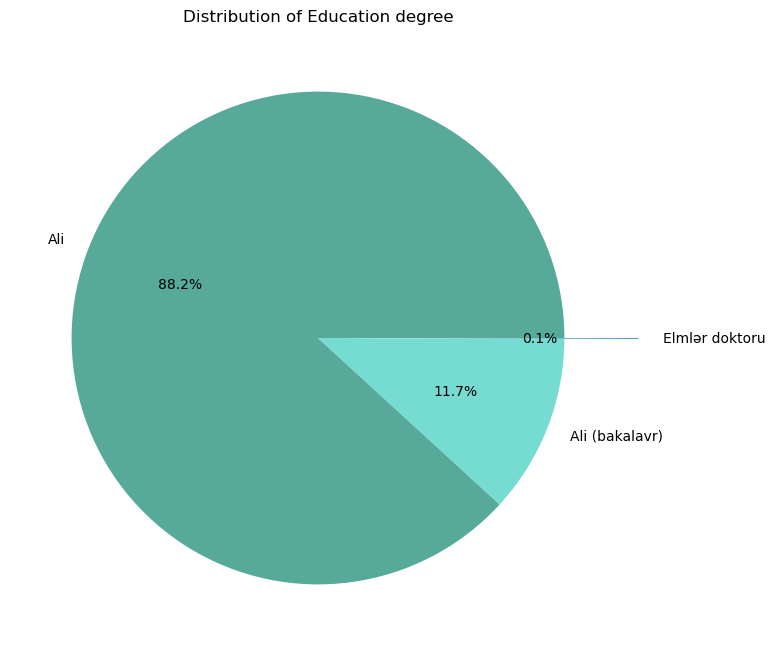

In [35]:
show_piechart(df_clean,"Education_degree")

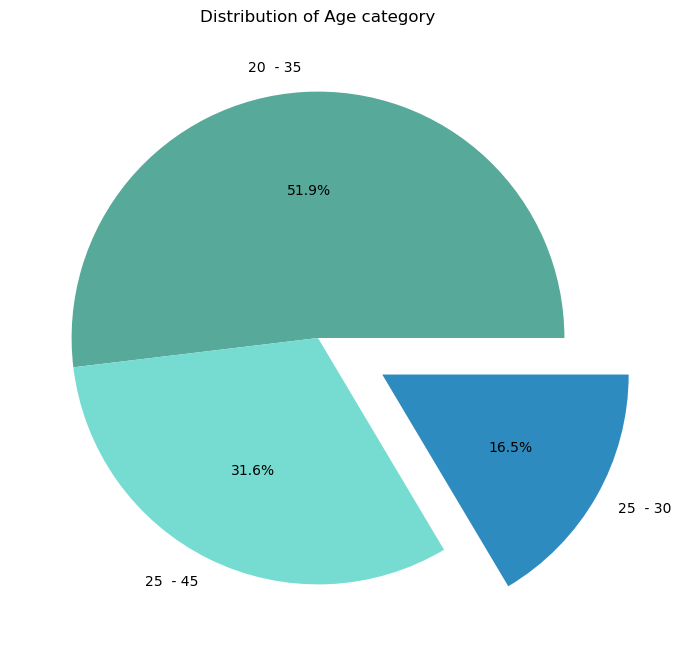

In [36]:
show_piechart(df_clean,"Age_category")

9


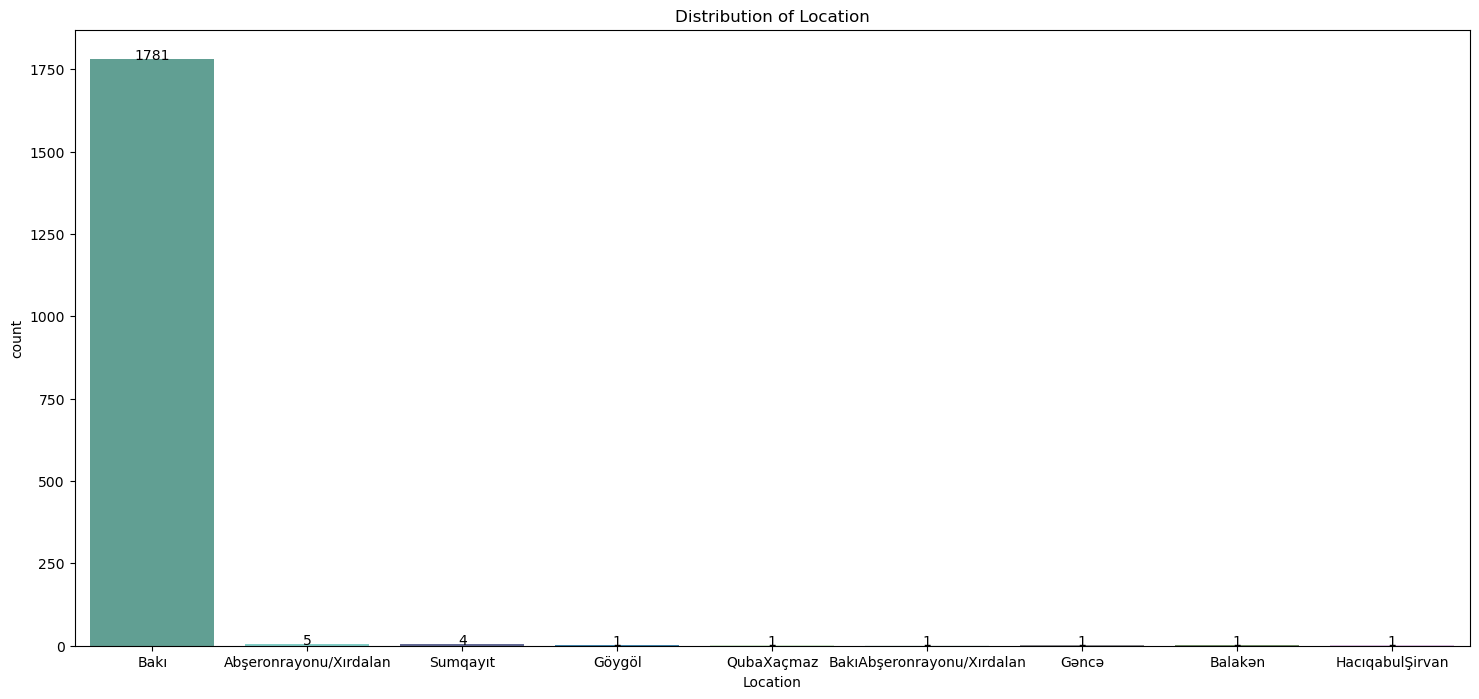

In [37]:
show_countplot(df_clean,"Location")

3


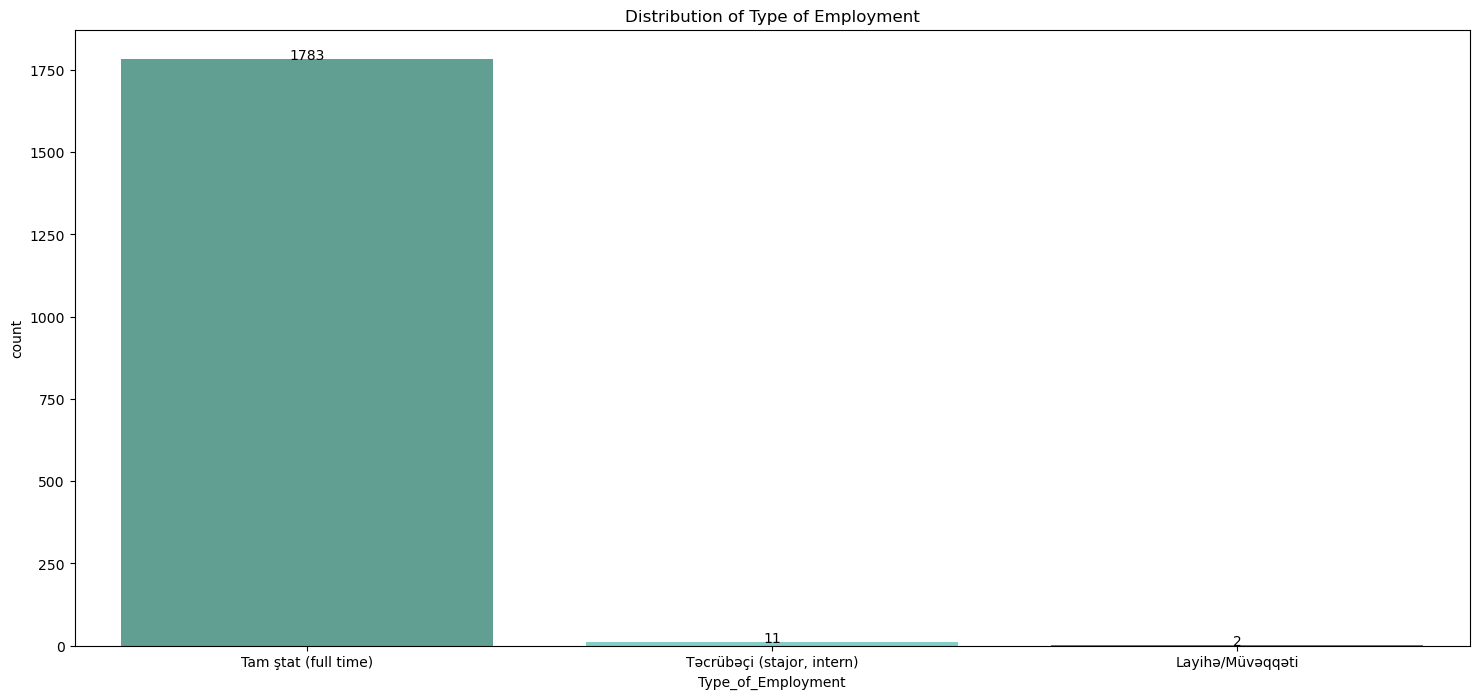

In [38]:
show_countplot(df_clean,"Type_of_Employment")

10


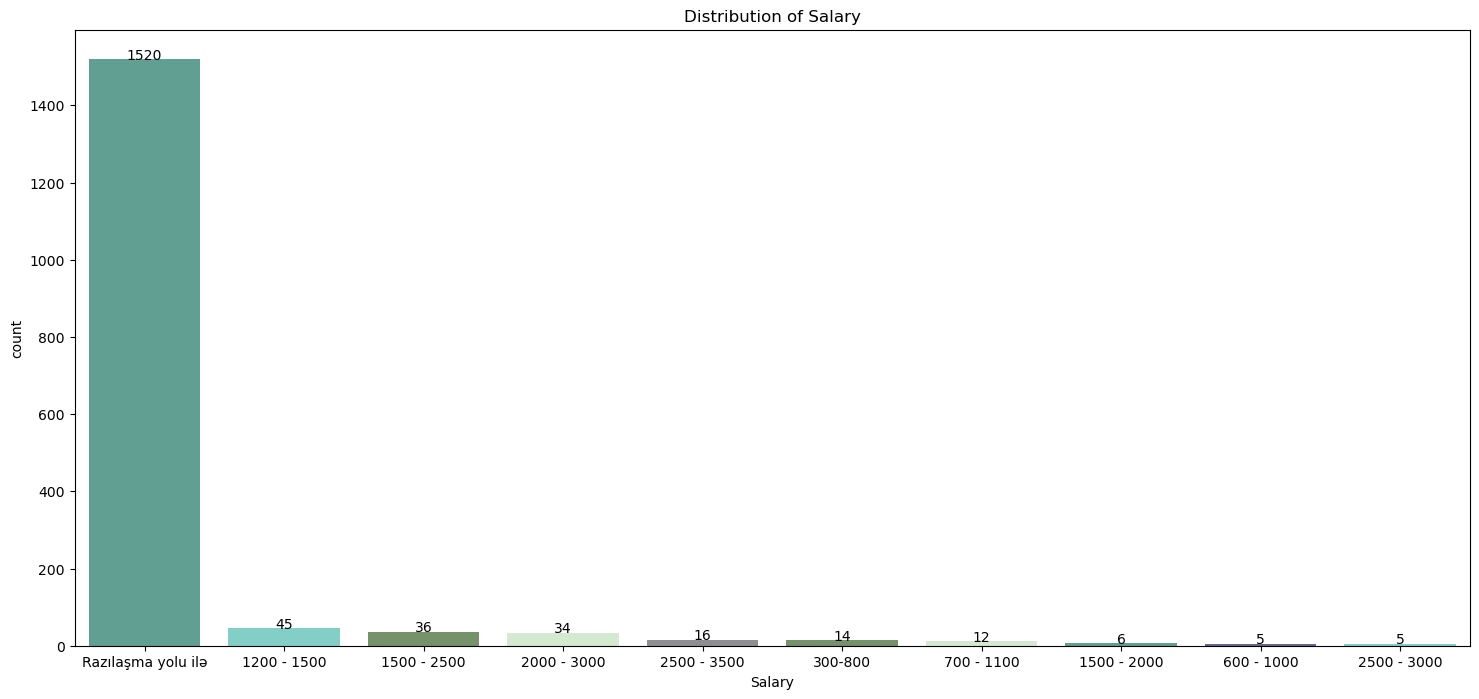

In [39]:
show_countplot(df_clean,"Salary",10)

10


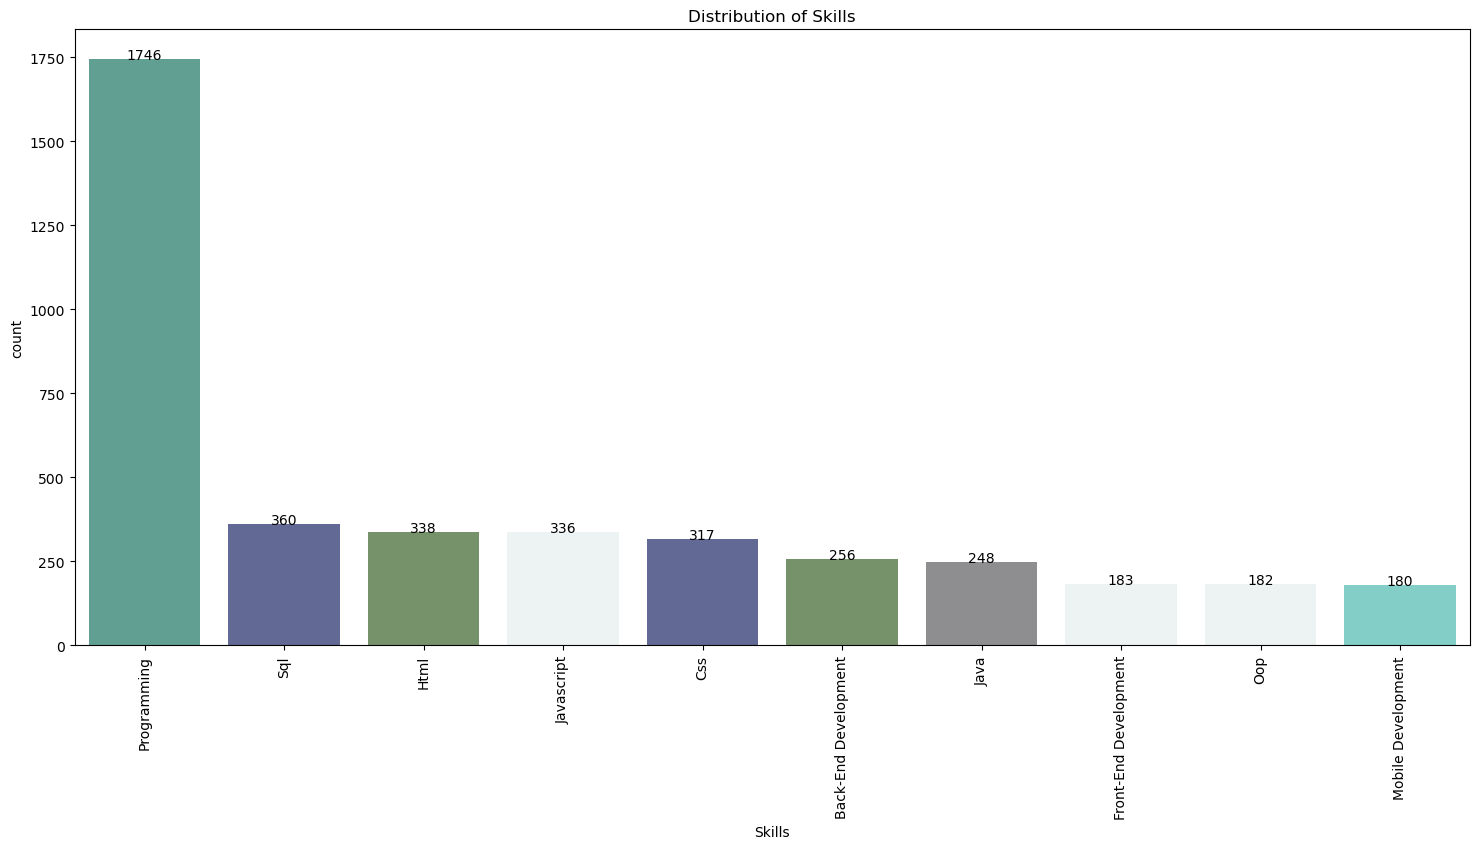

In [40]:
plt.xticks(rotation=90)
show_countplot(df_skill_extended,"Skills",10)

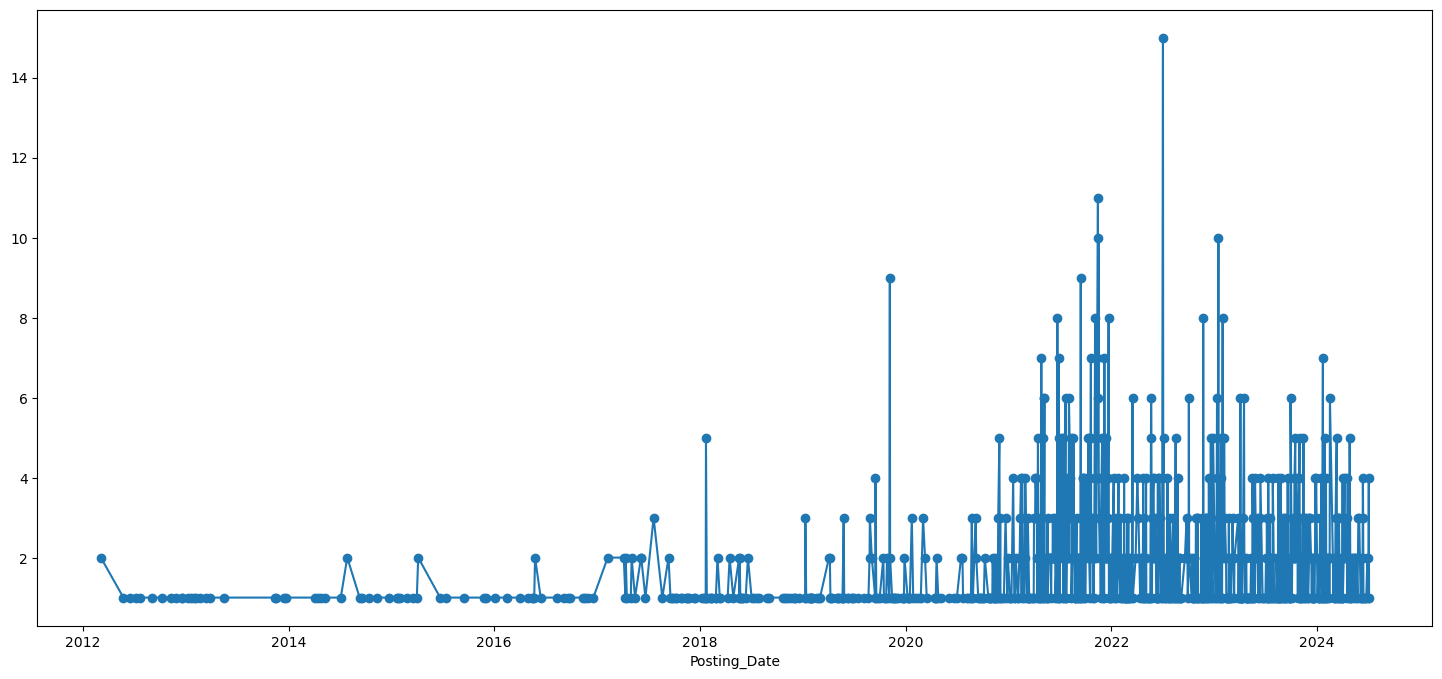

In [41]:
df_grouped = df_clean.groupby("Posting_Date").size().reset_index(name='Count')
show_plot(df_grouped,"Posting_Date","Count")

In [42]:
id_max = df_grouped["Count"].idxmax()
df_clean[df_clean["Posting_Date"]==df_grouped.iloc[id_max]["Posting_Date"]]

Name  \
755                          Senior Penetration Tester   
756  Biznes analitika üzrə Baş mütəxəssis (Proqram ...   
757                                  Android proqramçı   
758                Fullstack Seni̇or Laravel Proqramçı   
759  Proqram təminatının testləşdirilməsi üzrə mühə...   
760                                  Flutter Developer   
761                    Senior Software Engineer (Java)   
762  Avtomatlaşdırılmış əməliyyat sistemi üzrə proq...   
763  Front-end üzrə proqramçı (Rəqəmsal İnnovasiyal...   
764                                   Vue.js Developer   
765                            Back-end üzrə proqramçı   
766  Front-end üzrə proqramçı (Proqram təminatının ...   
767                                 DevSecOps Engineer   
768  Proqram təminatının testləşdirilməsi üzrə mühə...   
769                                Front End Developer   

                          Company Location    Type_of_Employment Age_category  \
755                    Cyberpoint     Bakı  Tam ştat (full time)          NaN   
756                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
757                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
758  Innovative Business Products     Bakı  Tam ştat (full time)          NaN   
759                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
760                   GTSolutions     Bakı  Tam ştat (full time)          NaN   
761              Digital Umbrella     Bakı  Tam ştat (full time)          NaN   
762                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
763                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
764              Digital Umbrella     Bakı  Tam ştat (full time)          NaN   
765                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
766                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
767                    Cyberpoint     Bakı  Tam ştat (full time)          NaN   
768                       ABB ASC     Bakı  Tam ştat (full time)          NaN   
769                 Dövlət qurumu     Bakı  Tam ştat (full time)          NaN   

    Education_degree              Salary Posting_Date Deadline_Date  \
755              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
756              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
757              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
758              Ali         4000 - 5000   2022-07-03    2022-08-03   
759              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
760              Ali          800 - 1200   2022-07-03    2022-08-03   
761              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
762              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
763              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
764              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
765              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
766              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
767              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
768              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   
769              Ali  Razılaşma yolu ilə   2022-07-03    2022-08-03   

                                                Skills   Id  Month    Year  \
755                    Programming, Mobile Development  755    7.0  2022.0   
756                        Programming, Xml, Sql, Json  756    7.0  2022.0   
757  Programming, Android Development, Mobile Devel...  757    7.0  2022.0   
758  Programming, Bootstrap, Laravel, Jquery, Javas...  758    7.0  2022.0   
759                         Programming, Oracle, Mysql  759    7.0  2022.0   
760  Programming, Xml, Flutter, Mobile Development,...  760    7.0  2022.0   
761                Programming, Java, Oop, Spring Boot  761    7.0  2022.0   
762                  Programming, Javascript, Oop, Sql  762    

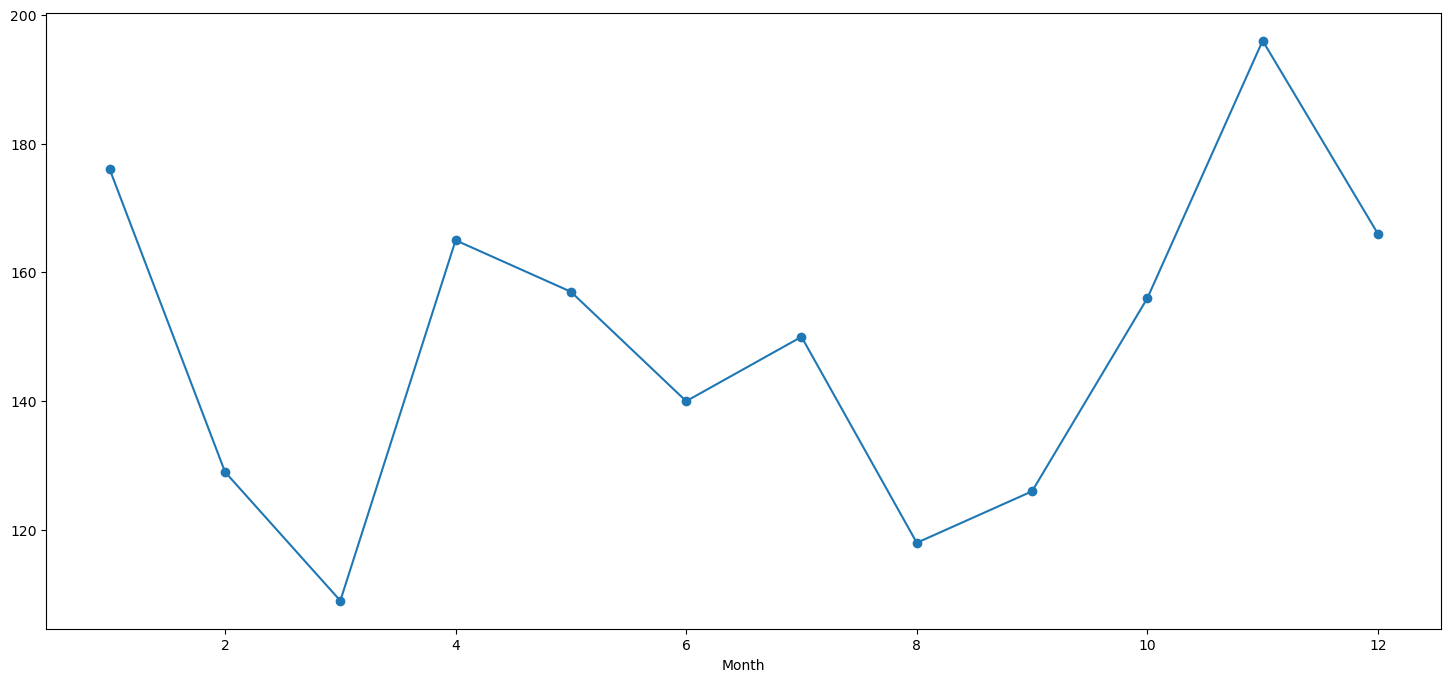

In [43]:
df_grouped = df_clean.groupby("Month").size().reset_index(name='Count')
show_plot(df_grouped,"Month","Count")

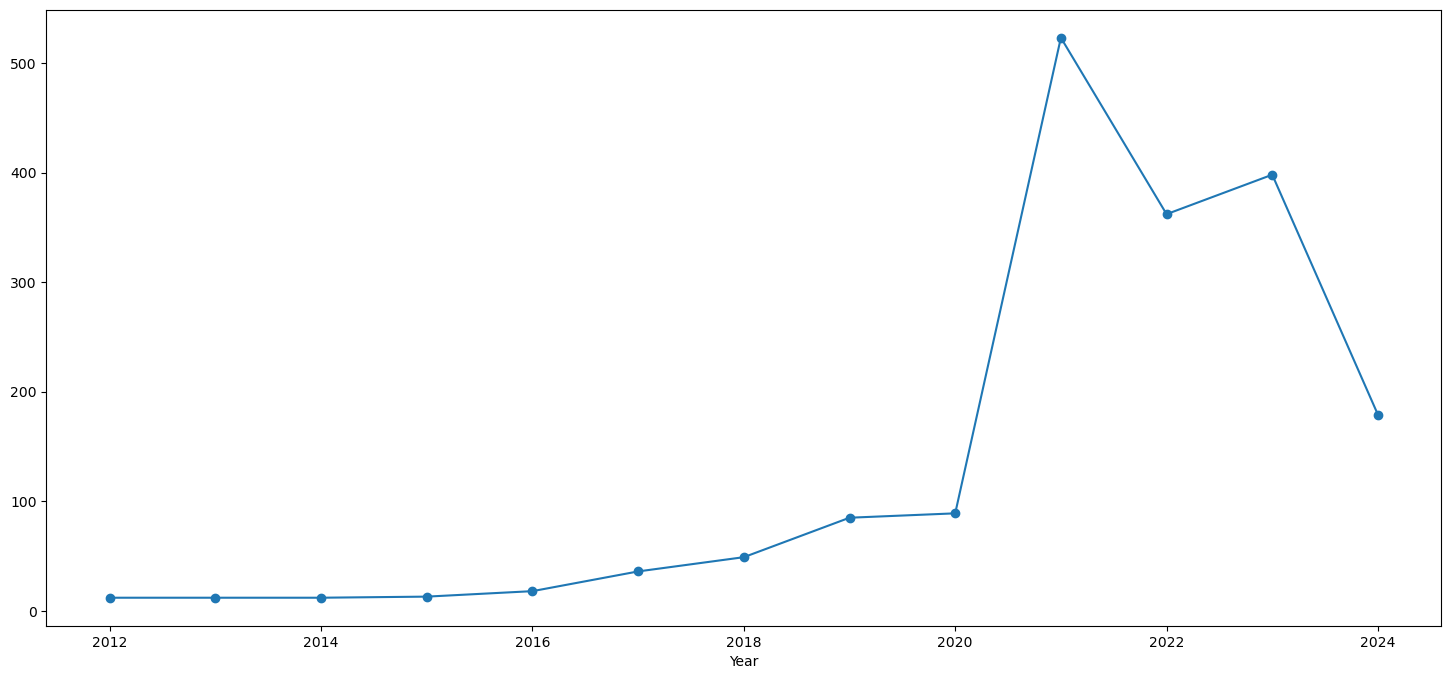

In [44]:
df_grouped = df_clean.groupby("Year").size().reset_index(name='Count')
show_plot(df_grouped,"Year","Count")

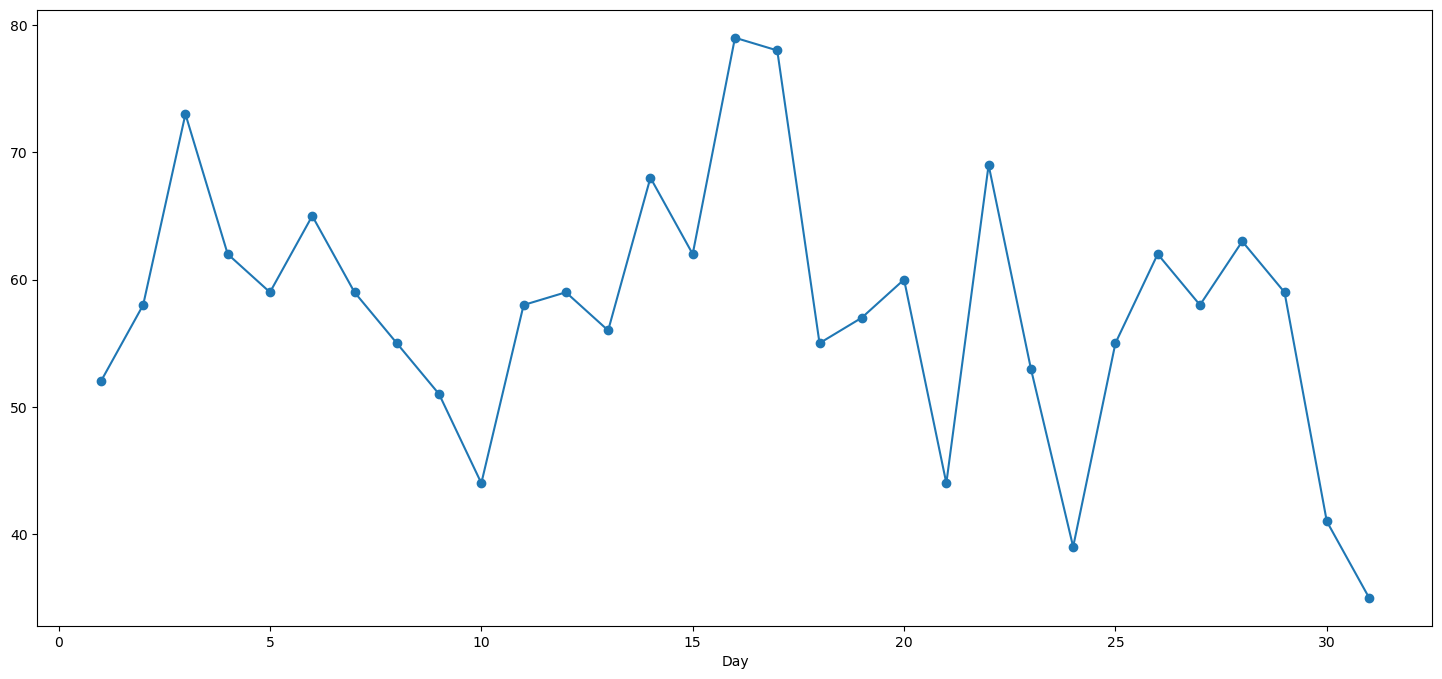

In [45]:
df_grouped = df_clean.groupby("Day").size().reset_index(name='Count')
show_plot(df_grouped,"Day","Count")

# 4. Feature enginering

### Functions
Create a functions

In [47]:
def update_salary(row, salary_and_name):
    if row["Name"] in salary_and_name["Name"].values:
        return salary_and_name[salary_and_name["Name"] == row["Name"]]["Salary"].values[0]
    return row["Salary"]

#----------------------------------------------------------------------------

def low_and_hight_salary(row,index):
    salary = row["Salary"].split("-")
    if len(salary)>1:
        return int(salary[index])
    return 0

#----------------------------------------------------------------------------

def mean_salary(row):
    salary = row["Salary"].split("-")
    if len(salary)>1:
        low = int(salary[0])
        high = int(salary[1])
        return ((high + low)/2)
    return 0

#----------------------------------------------------------------------------

def new_salary_features(data):
    data["Salary"] = data.apply(lambda row: update_salary(row, salary_and_name), axis=1)
    data["Low_Salary"]  = data.apply(lambda row: low_and_hight_salary(row,0),axis=1)
    data["High_Salary"]  = data.apply(lambda row: low_and_hight_salary(row,1),axis=1)
    data["Mean_Salary"]  = data.apply(lambda row: mean_salary(row),axis=1)

#----------------------------------------------------------------------------

def salary_null_replace(data):
    data["Mean_Salary"].replace({0:data["Mean_Salary"].mean()},inplace=True)
    data["Low_Salary"].replace({0:data["Low_Salary"].mean()},inplace=True)
    data["High_Salary"].replace({0:data["High_Salary"].mean()},inplace=True)

In [48]:
def vacancy_category(data):
    for index, row in data.iterrows():
        if re.search(r"front", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "Frontend Developer"

        elif re.search(r"back|java|c#|.net|python|php", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "Backend Developer"

        elif re.search(r"android", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "Android Developer"

        elif re.search(r"ios", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "IOS Developer"

        elif re.search(r"mobil|mobile", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "Mobile Developer"

        elif re.search(r"DevOps", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "DevOps"

        elif re.search(r"full", row["Name"], re.IGNORECASE):
            data.at[index, "Category"] = "FullStack Developer"
        else:
            data.at[index, "Category"] = "Software Developer"


In [49]:
def feature_encoding(col_name,data,data2=df_clean):
    counter = Counter(data2[col_name])
    data[f"{col_name}_encoded"] = data[col_name].apply(lambda x: int(counter[x]))

#----------------------------------------------------------------------------


def label_encoding(col_name,data):
    encoder = LabelEncoder()
    data[f"{col_name}_encoded"] = encoder.fit_transform(data[col_name] )

#----------------------------------------------------------------------------

def target_encoding(col_name,y,data):
    encoder = TargetEncoder()
    data[f"{col_name}_encoded"] =  encoder.fit_transform(data[[col_name]],data[y])


### `df_skill_extended` preprocessing

In [50]:
new_salary_features(df_skill_extended)
df_skill_extended.head(2)

Name   Company Location  \
0  Mobil tətbiq üzrə məhsul mütəxəssisi  189 Taxi     Bakı   
1  Mobil tətbiq üzrə məhsul mütəxəssisi  189 Taxi     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date              Skills  Id  Month    Year  Day  \
0   2024-07-04    2024-07-18         Programming   0    7.0  2024.0  4.0   
1   2024-07-04    2024-07-18  Mobile Development   0    7.0  2024.0  4.0   

   Low_Salary  High_Salary  Mean_Salary  
0           0            0          0.0  
1           0            0          0.0

In [51]:
salary_null_replace(df_skill_extended)

In [52]:
vacancy_category(df_skill_extended)

label_encoding("Category",df_skill_extended)
label_encoding("Mean_Salary",df_skill_extended)
label_encoding("Education_degree",df_skill_extended)
label_encoding("Type_of_Employment",df_skill_extended)
label_encoding("Location",df_skill_extended)
feature_encoding("Company",df_skill_extended)

target_encoding("Category","Mean_Salary",df_skill_extended)
target_encoding("Skills","Mean_Salary",df_skill_extended)

In [53]:
df_skill_extended[["Mean_Salary","Mean_Salary_encoded","Category","Category_encoded"]].value_counts()

Mean_Salary  Mean_Salary_encoded  Category             Category_encoded
709.69284    6                    Software Developer   1011.978823         1862
                                  Backend Developer    1220.528900         1579
                                  Frontend Developer   1106.113148          570
1350.00000   16                   Backend Developer    1220.528900          313
709.69284    6                    FullStack Developer  1022.684874          240
                                                                           ... 
2000.00000   26                   FullStack Developer  1022.684874            2
1000.00000   12                   Mobile Developer     1001.792056            2
1500.00000   19                   Backend Developer    1220.528900            2
1350.00000   16                   DevOps               1561.804581            2
475.00000    1                    Software Developer   1011.978823            1
Name: count, Length: 95, dtype: int64

In [54]:
df_skill_extended.groupby(["Mean_Salary"])["Skills"].sum()

Mean_Salary
450.00000     ProgrammingTcp/IpDnsDhcpProgrammingTcp/IpDnsDh...
475.00000                                           Programming
550.00000     ProgrammingIngilis DiliFront-End DevelopmentJa...
600.00000            ProgrammingJqueryJavascriptProgrammingHtml
650.00000     ProgrammingFront-End CodingFront-End Developme...
700.00000     ProgrammingBootstrapTypescriptFront-End Develo...
709.69284     ProgrammingMobile DevelopmentProgrammingBack-E...
750.00000     ProgrammingLaravelJqueryJavascriptMysqlLinuxHt...
800.00000     ProgrammingFront-End DevelopmentAdobe XdJavasc...
850.00000     ProgrammingTexniki DəstəkProgrammingПродажиTyp...
900.00000     ProgrammingDhcpLan/WanDnsHelpdeskProgrammingTə...
950.00000     ProgrammingFront-End DevelopmentJavascriptHtml...
1000.00000    ProgrammingMobile DevelopmentProgrammingC#OopP...
1050.00000    ProgrammingJavaProgrammingOracleSqlHtmlCssJava...
1100.00000    ProgrammingEnglish LanguageRussian LanguageIng...
1150.00000                  

<Axes: >

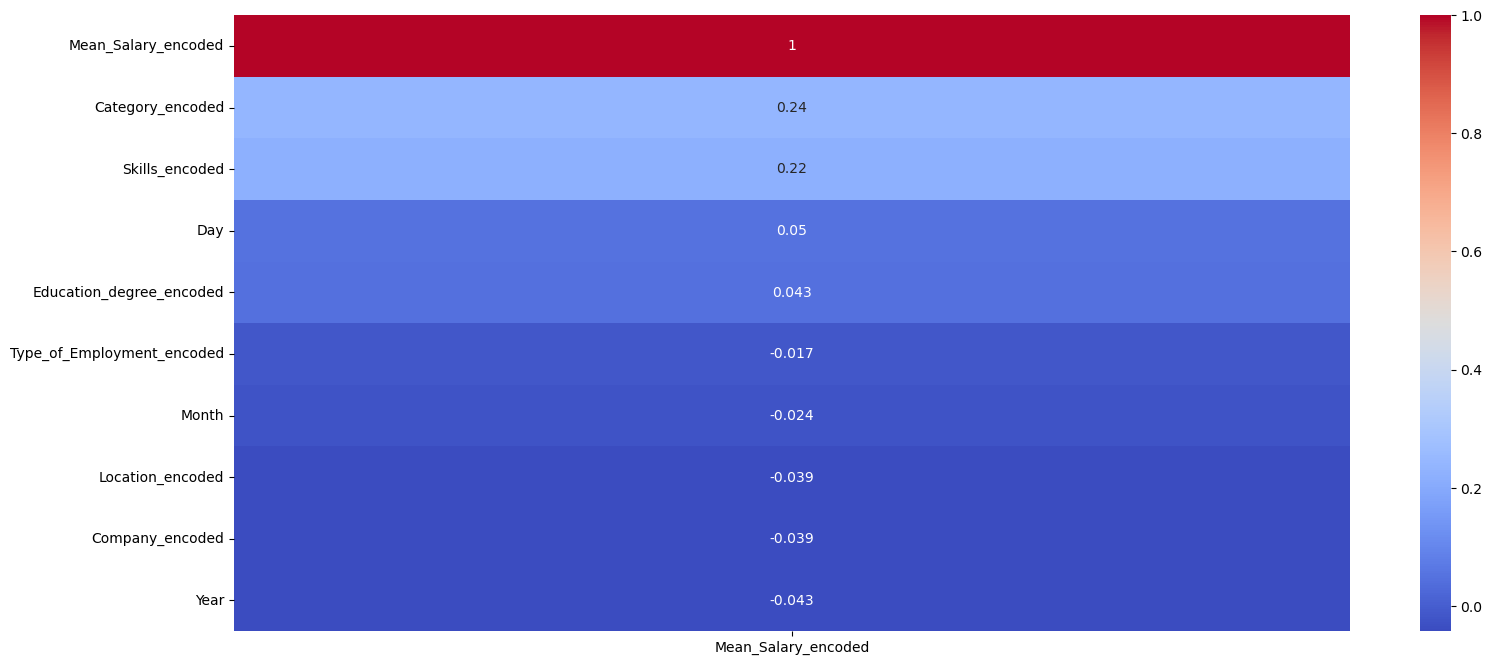

In [55]:
sns.heatmap(
    df_skill_extended.select_dtypes(include="number").drop(["Mean_Salary","High_Salary","Low_Salary","Id"],axis=1).corr()
    ["Mean_Salary_encoded"].to_frame().sort_values(by="Mean_Salary_encoded",ascending=False),
    annot=True,
    cmap="coolwarm",
    cbar=True
)

In [56]:
df_skill_extended.head()

Name         Company Location  \
0  Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1  Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
2              Senior Backend Developer  Ferrum Capital     Bakı   
3              Senior Backend Developer  Ferrum Capital     Bakı   
4              Senior Backend Developer  Ferrum Capital     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
2  Tam ştat (full time)          NaN              Ali         3000 - 5000   
3  Tam ştat (full time)          NaN              Ali         3000 - 5000   
4  Tam ştat (full time)          NaN              Ali         3000 - 5000   

  Posting_Date Deadline_Date              Skills  ...  High_Salary  \
0   2024-07-04    2024-07-18         Programming  ...   842.283699   
1   2024-07-04    2024-07-18  Mobile Development  ...   842.283699   
2   2024-07-03    2024-07-17         Programming  ...  5000.000000   
3   2024-07-03    2024-07-17               T-Sql  ...  5000.000000   
4   2024-07-03    2024-07-17              Oracle  ...  5000.000000   

   Mean_Salary           Category  Category_encoded  Mean_Salary_encoded  \
0    709.69284   Mobile Developer       1001.792056                    6   
1    709.69284   Mobile Developer       1001.792056                    6   
2   4000.00000  Backend Developer       1220.528900                   37   
3   4000.00000  Backend Developer       1220.528900                   37   
4   4000.00000  Backend Developer       1220.528900                   37   

   Education_degree_encoded  Type_of_Employment_encoded Location_encoded  \
0                         0                           1                1   
1                         0                           1                1   
2                         0                           1                1   
3                         0                           1                1   
4                         0                           1                1   

   Company_encoded  Skills_encoded  
0                2     1157.565625  
1                2     1432.031827  
2               26     1157.565625  
3               26      931.786407  
4               26     1171.410651  

[5 rows x 25 columns]

In [57]:
df_skill_extended.to_excel("../Software Vacancy Skill Extended.xlsx")

### `df_clean` Preprocessing

In [58]:
new_salary_features(df_clean)
salary_null_replace(df_clean)
df_clean.head(2)

Name         Company Location  \
0  Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1              Senior Backend Developer  Ferrum Capital     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali         3000 - 5000   

  Posting_Date Deadline_Date  \
0   2024-07-04    2024-07-18   
1   2024-07-03    2024-07-17   

                                              Skills  Id  Month    Year  Day  \
0                    Programming, Mobile Development   0    7.0  2024.0  4.0   
1  Programming, T-Sql, Oracle, Oop, Java, Back-En...   1    7.0  2024.0  3.0   

    Low_Salary  High_Salary  Mean_Salary  
0   579.259465    854.67706   716.968263  
1  3000.000000   5000.00000  4000.000000

In [59]:
vacancy_category(df_clean)
df_clean.head()

Name         Company Location  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1                           Senior Backend Developer  Ferrum Capital     Bakı   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...       Xalq Bank     Bakı   
3                                  Mid IOS Developer      Golden Pay     Bakı   
4                             IOS Developer (middle)    Express Bank     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali         3000 - 5000   
2  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date  \
0   2024-07-04    2024-07-18   
1   2024-07-03    2024-07-17   
2   2024-07-03    2024-07-17   
3   2024-07-03    2024-07-17   
4   2024-07-03    2024-07-17   

                                              Skills  Id  Month    Year  Day  \
0                    Programming, Mobile Development   0    7.0  2024.0  4.0   
1  Programming, T-Sql, Oracle, Oop, Java, Back-En...   1    7.0  2024.0  3.0   
2             Programming, Back-End Development, Sql   2    7.0  2024.0  3.0   
3   Programming, Ios Development, Mobile Development   3    7.0  2024.0  3.0   
4                  Programming, Ios Development, Oop   4    7.0  2024.0  3.0   

    Low_Salary  High_Salary  Mean_Salary           Category  
0   579.259465    854.67706   716.968263   Mobile Developer  
1  3000.000000   5000.00000  4000.000000  Backend Developer  
2   579.259465    854.67706   716.968263  Backend Developer  
3   579.259465    854.67706   716.968263      IOS Developer  
4   579.259465    854.67706   716.968263      IOS Developer

In [60]:
label_encoding("Category",df_clean)
label_encoding("Mean_Salary",df_clean)
label_encoding("Education_degree",df_clean)
label_encoding("Type_of_Employment",df_clean)
label_encoding("Location",df_clean)
feature_encoding("Company",df_clean)

target_encoding("Category","Mean_Salary",df_clean)


In [61]:
df_clean['Skills'] = df_clean['Skills'].apply(lambda x: x.split(', '))

all_skills = [skill for sublist in df_clean['Skills'] for skill in sublist]

encoder = LabelEncoder().fit(all_skills)
df_clean['Skills_encoded'] = df_clean['Skills'].apply(lambda x: encoder.transform(x).tolist())
df_clean.head()

Name         Company Location  \
0               Mobil tətbiq üzrə məhsul mütəxəssisi        189 Taxi     Bakı   
1                           Senior Backend Developer  Ferrum Capital     Bakı   
2  Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...       Xalq Bank     Bakı   
3                                  Mid IOS Developer      Golden Pay     Bakı   
4                             IOS Developer (middle)    Express Bank     Bakı   

     Type_of_Employment Age_category Education_degree              Salary  \
0  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
1  Tam ştat (full time)          NaN              Ali         3000 - 5000   
2  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
3  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   
4  Tam ştat (full time)          NaN              Ali  Razılaşma yolu ilə   

  Posting_Date Deadline_Date  \
0   2024-07-04    2024-07-18   
1   2024-07-03    2024-07-17   
2   2024-07-03    2024-07-17   
3   2024-07-03    2024-07-17   
4   2024-07-03    2024-07-17   

                                              Skills  ...  High_Salary  \
0                  [Programming, Mobile Development]  ...    854.67706   
1  [Programming, T-Sql, Oracle, Oop, Java, Back-E...  ...   5000.00000   
2           [Programming, Back-End Development, Sql]  ...    854.67706   
3  [Programming, Ios Development, Mobile Developm...  ...    854.67706   
4                [Programming, Ios Development, Oop]  ...    854.67706   

   Mean_Salary           Category  Category_encoded  Mean_Salary_encoded  \
0   716.968263   Mobile Developer       1128.678754                    6   
1  4000.000000  Backend Developer       1223.818821                   37   
2   716.968263  Backend Developer       1223.818821                    6   
3   716.968263      IOS Developer       1558.484779                    6   
4   716.968263      IOS Developer       1558.484779                    6   

   Education_degree_encoded  Type_of_Employment_encoded Location_encoded  \
0                         0                           1                1   
1                         0                           1                1   
2                         0                           1                1   
3                         0                           1                1   
4                         0                           1                1   

   Company_encoded                 Skills_encoded  
0                2                     [186, 152]  
1               26  [186, 222, 164, 163, 121, 29]  
2               28                 [186, 29, 213]  
3               18                [186, 114, 152]  
4               30                [186, 114, 163]  

[5 rows x 25 columns]

In [62]:
df_clean.to_excel("../Software Vacancy Clean.xlsx")

# X and Y split

In [63]:
x = df_skill_extended.select_dtypes(include="number").drop(["Id","Mean_Salary","Mean_Salary_encoded","High_Salary","Low_Salary","Day","Month","Year"],axis=1)
y = df_skill_extended["Mean_Salary_encoded"]
y.nunique()


39

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=25)
x_train.head()
y_test.nunique(),y_train.nunique()

(37, 39)

# 5. Machine Learning
* Create a function that take model and param for this model
* Check diffrent models

In [65]:
def create_model(model,param_grid):

  model_name = model.__class__.__name__

  gs = GridSearchCV(
        model,
        param_grid,
        cv=2,
        refit=True)

  gs.fit(x_train,y_train)

  with open(f"../skill_classification_models/{model_name}.pkl","wb") as file:
    pickle.dump(gs,file)

  print(f"\n{model_name}\nTrain accuracy {accuracy_score(y_train,gs.predict(x_train))}")
  print("Test report\n",classification_report(y_test,gs.predict(x_test)))

* LogisticRegression
    * Train: 63%
    * Test:63%

In [66]:
create_model(LogisticRegression(random_state = 42),
 {"penalty": ["l1", "l2"],
  "C": [0.001, 0.007, 0.01, 0.1],
  "solver": ['liblinear', 'saga']})


LogisticRegression
Train accuracy 0.632141040854382
Test report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.63      1.00      0.77       926
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00         5
          16       1.00      0.01      0.02       113
          17       0.00      0.00      0.00         1
          18   

In [67]:
with open(f"../skill_classification_models/LogisticRegression.pkl","rb") as file:
    log_reg = pickle.load(file)

best_model = log_reg.best_estimator_
best_model.coef_

array([[-1.11967107e-03, -8.84696038e-02,  6.75017722e-02,
         1.27078833e-02, -4.53020922e-01, -2.90895602e-03],
       [-1.05239275e-02, -1.08960865e-02,  3.51563323e-03,
        -1.80375654e-03, -1.42813536e-01,  3.22850652e-03],
       [-1.07439744e-03, -5.38439753e-01,  6.78010939e-02,
        -7.95326084e-02, -5.08639005e-02, -2.21331713e-03],
       [-1.08479559e-02, -3.57956010e-02,  1.21281548e-02,
         4.01706186e-01, -1.85885252e-01,  4.40900849e-03],
       [-1.57793371e-02, -1.19241481e-01, -3.53352540e-02,
        -1.19008655e-02,  9.90788702e-02,  6.74165404e-03],
       [-2.90283357e-03, -4.86651351e-02, -9.08071617e-03,
        -2.35463696e-02, -1.06177709e-02, -3.39276226e-03],
       [-1.16931464e-03,  1.58326757e-01,  8.98472505e-01,
         1.18292579e+00,  1.35049916e-02, -1.69676599e-03],
       [-4.61097159e-03,  6.11040975e-02, -7.12431158e-02,
        -1.12524317e-01, -1.20533675e-02, -2.38062911e-04],
       [-2.26903098e-03, -5.01055598e-01,  7.139

* RandomForest
    * Train: 69%
    * Test:66%

In [68]:
create_model(RandomForestClassifier(random_state=42),
 {"n_estimators": [150,200,300],
  "criterion": ["gini","entropy"],
  "bootstrap": [True,False],
  "max_depth": [3,5,9]})


RandomForestClassifier
Train accuracy 0.6967282590269537
Test report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.67      0.99      0.80       926
           7       0.00      0.00      0.00         3
           8       0.60      0.27      0.38        11
           9       0.00      0.00      0.00         3
          10       1.00      0.10      0.17        21
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00         5
          16       0.74      0.15      0.25       113
          17       0.00      0.00      0.00         1
          

* SVC
    * Train: 63%
    * Test:63%

In [69]:
create_model(SVC(random_state=42),
 {"kernel": ["rbf","linear"],
  "gamma": [0.1,0.4,0.7],
  "C": [0.001,0.004,0.01]})


SVC
Train accuracy 0.6316324800813697
Test report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.63      1.00      0.77       926
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00         5
          16       0.00      0.00      0.00       113
          17       0.00      0.00      0.00         1
          18       0.00      

* LGBMClassifier
  * Train : 76%
  * Test: 68%

In [70]:
create_model(lgb.LGBMClassifier(),
 {"learning_rate": [0.05, 0.1, 0.2, 0.3],
  "num_iterations ": [160,250,300]})

[LightGBM] [Warning] num_iterations is set=, num_iterations=100 will be ignored. Current value: num_iterations=
[LightGBM] [Warning] Unknown parameter: 160
[LightGBM] [Warning] num_iterations is set=, num_iterations=100 will be ignored. Current value: num_iterations=
[LightGBM] [Warning] Unknown parameter: 160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 2949, number of used features: 4
[LightGBM] [Info] Start training from score -6.602927
[LightGBM] [Info] Start training from score -7.989221
[LightGBM] [Info] Start training from score -4.351635
[LightGBM] [Info] Start training from score -7.296074
[LightGBM] [Info] Start training from score -6.043311
[LightGBM] [Info] Start training from score -7.296074
[LightGBM] [In

* XGB    
    * Train: 68%
    * Test:67%

In [71]:
create_model(XGBClassifier(),
 {
  "learning_rate": [0.05, 0.1, 0.3],
  "max_depth": [3, 5, 7],
  "n_estimators": [150, 220, 320],
  "gamma": [0.01, 0.04, 0.1],
  "subsample": [0.7, 0.9, 1.0],
 })


XGBClassifier
Train accuracy 0.6828275978979488
Test report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.60      0.17      0.26        18
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.67      0.99      0.80       926
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         3
          10       0.67      0.10      0.17        21
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       1.00      0.14      0.25        14
          14       0.00      0.00      0.00         5
          16       0.88      0.13      0.23       113
          17       0.00      0.00      0.00         1
          18       

* CatBoost
    * Train: 72%
    * Test: 68%

In [72]:
create_model(CatBoostClassifier(),
 {
  "learning_rate": [0.05, 0.1, 0.2, 0.3],
  "depth": [ 5, 7, 9],
 })


0:	learn: 3.1208370	total: 184ms	remaining: 3m 3s
1:	learn: 2.8310673	total: 197ms	remaining: 1m 38s
2:	learn: 2.6518739	total: 211ms	remaining: 1m 10s
3:	learn: 2.5141691	total: 227ms	remaining: 56.5s
4:	learn: 2.4065158	total: 240ms	remaining: 47.7s
5:	learn: 2.3175795	total: 253ms	remaining: 41.9s
6:	learn: 2.2403272	total: 267ms	remaining: 37.9s
7:	learn: 2.1668974	total: 282ms	remaining: 34.9s
8:	learn: 2.1079933	total: 296ms	remaining: 32.6s
9:	learn: 2.0570679	total: 310ms	remaining: 30.7s
10:	learn: 2.0109572	total: 320ms	remaining: 28.7s
11:	learn: 1.9684403	total: 334ms	remaining: 27.5s
12:	learn: 1.9300458	total: 345ms	remaining: 26.2s
13:	learn: 1.8948829	total: 359ms	remaining: 25.3s
14:	learn: 1.8635752	total: 373ms	remaining: 24.5s
15:	learn: 1.8363817	total: 387ms	remaining: 23.8s
16:	learn: 1.8098027	total: 402ms	remaining: 23.2s
17:	learn: 1.7862914	total: 416ms	remaining: 22.7s
18:	learn: 1.7635695	total: 430ms	remaining: 22.2s
19:	learn: 1.7426628	total: 440ms	remai

# 6. Conclusion
### The best-performing models are CatBoost and XGBoost.
Although LightGBM achieved a higher score on the training data, it underperformed on the test data, with an 8% difference, indicating overfitting.